# Sampling Method

@author: Yi, Jul 26 2020

本文介绍 Rejection Sampling, Metropolis Hastings Sampling, Gibbs Sampling 的实现及可视化。

In [1]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

## Rejection Sampling

拒绝采样的目标分布 $\tilde{p}$ 是可以 **unnormalized** 的。

proposal 分布 $q$ 可以是任意分布，但是要求找到一个常数 M 使得 $Mq(x) \ge \tilde{p}(x)$。

采样时，从 $q(\cdot)$ 里采一个 $x$，并按照 $\tilde{p}(x)/Mq(x)$ 的几率被接受。

一个好的分布 $q$ 是长得像 $p$ 的分布，会有较高的接受率。

** TIPS: **  可以尝试修改下面代码中的函数，给定不同的 proposal 分布，观察接受率的变化:

- *q(x)* proposal 分布的概率密度（可以是 unnormalized 的）
- *sample_from_q()* 从 proposal 分布中采样

accept rate: 0.2113


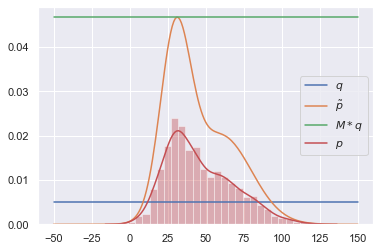

In [42]:
sns.set()

# 未归一化的概率密度，将 n 个 x 映射到 n 个 p~
def p(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=60, scale=20)

# 按照 uniform(-50, 150) 分布采样
# def q(x):
#     return np.ones_like(x) / 200
# def sample_from_q():
#     return np.random.uniform(-50, 150)

# 按照 N(30, 40) 采样
def q(x):
    return st.norm.pdf(x, loc=30, scale=40)
def sample_from_q():
    return np.random.normal(30, 40)

# 按照 N(80, 50) 采样
# def q(x):
#     return st.norm.pdf(x, loc=80, scale=50)
# def sample_from_q():
#     return np.random.normal(80, 50)


# 开始采样
x = np.arange(-50, 151)
M = max(p(x) / q(x))
iter = 10000

samples = []
for i in range(iter):
    z = sample_from_q()
    u = np.random.uniform(0, 1)
    if u <= p(z) / (M * q(z)):
        samples.append(z)


plt.plot(x, q(x), label='$q$')
plt.plot(x, p(x), label=r'$\tilde{p}$')
plt.plot(x, M*q(x), label=r'$M*q$')
plt.legend()

sns.distplot(samples, kde_kws={'label': r'$p$'})
print('accept rate:', len(samples)/iter)


## Metropolis Hastings Sampling

如果说 Rejection 采样是一种根据某个固定的 proposal 进行采样，那么 MH 采样是一种动态 proposal 的采样。先在空间中选一个点，然后以该点为中心设计一个 proposal，来探索周围的区域，在随机游走的过程中，尽量 explore 整个空间。

步骤：
- 初始化一个样本点。
- 反复采样：
  - 从 proposal 分布中 sample 出状态的转移：$q(x'|x)$ 。
  - 计算接受概率 $min(1, \frac{q(x|x')p(x')}{q(x'|x)p(x)})$，根据该接受概率决定是否接受。

注意：如果使用一个对称的高斯分布作为 proposal 分布，那么由于高斯分布的对称性，会使得接受概率变成：$min(1, \frac{p(x')}{p(x)})$，这说明了：
- 如果转移到的那个点 $x'$ 概率比当前的点 $x$ 大，接受概率为 1，无脑转就完事了。
- 如果转移到的那个点 $x'$ 概率比当前的点 $x$ 小，接受概率为 $\frac{p(x')}{p(x)}$，按照一定的概率转，一定的概率留在原地。

也就是说：**MH 采样倾向于探索高概率地区**。

(0, 15)

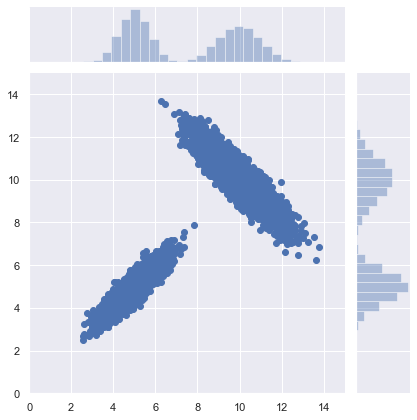

In [121]:
# 假设要采样的分布是包含两个分布的混合高斯分布，来自两个 component 的概率相同
# 每个分布的均值方差如下：
mean1 = np.array([5, 5])
cov1 = np.array([[0.5, 0.45], [0.45, 0.5]])
mean2 = np.array([10, 10])
cov2 = np.array([[1.0, -0.9], [-0.9, 1.0]])

# 概率密度函数是两个高斯分布的直接加和：
# p(x, y) = \sigma_c p(x, y, c)
# 这里其实是 unnormalized 的，comp1 和 comp2 都应该除以 2
def p(x, y):
    comp1 = st.multivariate_normal.pdf([x, y], mean=mean1, cov=cov1)
    comp2 = st.multivariate_normal.pdf([x, y], mean=mean2, cov=cov2)
    return comp1 + comp2

# 真实样本点，实际分布可能是无法采的
def sample_real_samples_from_p():
    samples1 = np.random.multivariate_normal(mean1, cov1, 5000)
    samples2 = np.random.multivariate_normal(mean2, cov2, 5000)
    samples = np.concatenate([samples1, samples2], axis=0)
    return samples

real_samples = sample_real_samples_from_p()
plt = sns.jointplot(real_samples[:, 0], real_samples[:, 1])
plt.ax_marg_x.set_xlim(0, 15)
plt.ax_marg_y.set_ylim(0, 15)

我们使用高斯分布来作为 proposal 分布。

** TIPS **： 

- 可以尝试修改不同的 x/y 初始点，来观察 MH 采样的结果。
  - 如果 x0/y0 来自低概率地区，需要一个 burn-in 的过程（也就是向高概率地区转移的过程），因此一般会把开始的点删掉。
- 可以尝试修改 proposal 分布的方差。
  - 方差越小，探索范围越小，容易局限在某些地方。比如掉在一个 component 里出不去。
  - 方差越大，探索范围越大，越容易在低概率地区瞎探索，导致高概率地区的样本少。

(0, 15)

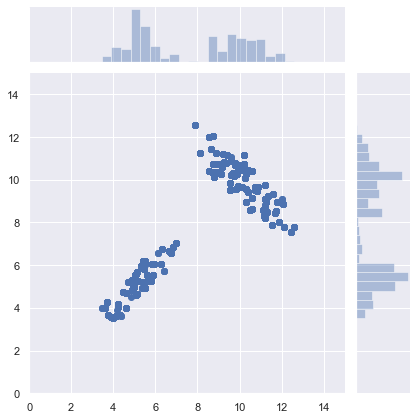

In [125]:
N = 10000
# 低概率地区的 x0/y0
# x0, y0 = 10, 1
# 高概率地区的 x0/y0
x0, y0 = 5, 5

# 可以尝试 0.1/2.0/10.0
q_sigma = 2.0

def metropolis_hastings(p, iter, x0, y0, q_sigma):
    x, y = x0, y0
    samples = []

    for i in range(iter):
        x_star, y_star = np.array([x, y]) + np.random.normal(0, q_sigma, size=2)
        if np.random.rand() < min(1, p(x_star, y_star) / p(x, y)):
            x, y = x_star, y_star
        samples.append([x, y])
    samples = np.array(samples)
    return samples

samples = metropolis_hastings(p, N, x0, y0, q_sigma)
plt = sns.jointplot(samples[:, 0], samples[:, 1])
plt.ax_marg_x.set_xlim(0, 15)
plt.ax_marg_y.set_ylim(0, 15)

## Gibbs Sampling

Gibbs 采样是一种特殊的 M-H 采样，每次只变换一个维度，令 $q(x'|x) = q(x_i'|x_{-i})$。（这里我写对了没有？待考证。）

众所周知，计算接受率时，如果 $q$ 和 $p$ 是一样的，那么接受率为 1，非常高效。如果 $p(x_i|x_{-i})$ 是已知的，直接令 $q(x'|x) = p(x_i'|x_{-i})$，那就无脑接受，非常高效。

Gibbs Sampling 适用于高维情况下，维度间的采样。假设维度之间的条件分布已知。每次通过 fix 其他维度的值，在当前维度上进行采样。

缺点：要知道条件分布。

这个和 Variance Inference 有共通之处。

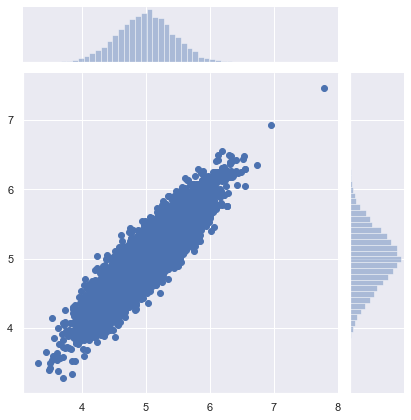

In [126]:
N = 10000
mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])

# 对于单元高斯分布，可以计算 p(x|y)
def p_x_given_y(y, mus, sigmas):
    mu = mus[0] + sigmas[1, 0] / sigmas[0, 0] * (y - mus[1])
    sigma = sigmas[0, 0] - sigmas[1, 0] / sigmas[1, 1] * sigmas[1, 0]
    return np.random.normal(mu, sigma)

# 对于单元高斯分布，可以计算 p(y|x)
def p_y_given_x(x, mus, sigmas):
    mu = mus[1] + sigmas[0, 1] / sigmas[1, 1] * (x - mus[0])
    sigma = sigmas[1, 1] - sigmas[0, 1] / sigmas[0, 0] * sigmas[0, 1]
    return np.random.normal(mu, sigma)

def gibbs_sampling(mus, sigmas, iter):
    samples = np.zeros((iter, 2))
    y0 = 5

    for i in range(iter):
        x = p_x_given_y(y, mus, sigmas)
        y = p_y_given_x(x, mus, sigmas)
        samples[i, :] = [x, y]

    return samples

samples = gibbs_sampling(mus, sigmas, N)
sns.jointplot(samples[:, 0], samples[:, 1])
